# Creating the vertical coordinate system

ROMS uses a terrain-following coordinate system. The vertical coordinate system is important when creating input fields that have a depth dimension, such as the initial conditions or the boundary forcing. Similar to the grid, the vertical coordinate system needs to be consistent for the creation of initial conditions, boundary forcings etc. To facilitate consistency, `ROMS-Tools` provides a dedicated object that defines the vertical coordinate system, ensuring it can be reused in subsequent steps, such as generating initial conditions and boundary forcing.

Since the vertical coordinate system depends on the horizontal grid, we start by creating our grid.

In [1]:
from roms_tools import Grid

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

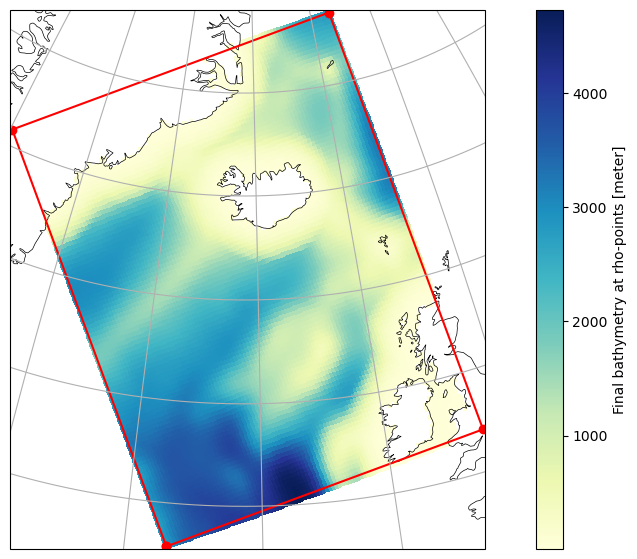

In [3]:
grid.plot(bathymetry=True)

Next, we create the vertical coordinate system according to
<cite data-cite="shchepetkin_correction_2009">(Shchepetkin and McWilliams, 2009)</cite>, see also Figure 2 in
<cite data-cite="lemarie_are_2012">(Lemarié et al., 2012)</cite>.

In [4]:
from roms_tools import VerticalCoordinate

In [5]:
vertical_coordinate = VerticalCoordinate(
    grid=grid,
    N=50,  # number of vertical levels
    theta_s=10.0,  # surface control parameter
    theta_b=2.0,  # bottom control parameter
    hc=400.0,  # critical depth
)

To construct the vertical coordinate system, `ROMS-Tools` first computes the S-coordinate and S-coordinate stretching curves, from which it can infer the layer and interface depths at rho-, u-, and v-points. All of this information is held by an xarray Dataset, accessible via the `.ds` property.

In [6]:
vertical_coordinate.ds

<xarray.Dataset> Size: 13MB
Dimensions:              (s_rho: 50, eta_v: 101, xi_rho: 102, eta_rho: 102,
                          xi_u: 101, s_w: 51)
Coordinates:
    lat_rho              (eta_v, xi_rho) float64 82kB 48.04 48.1 ... 73.51 73.53
    lon_rho              (eta_v, xi_rho) float64 82kB 332.9 333.1 ... 353.2
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 2MB 2.799e+03 ... 3...
    layer_depth_u        (eta_rho, xi_u, s_rho) float32 2MB 2.799e+03 ... 3.497
    layer_depth_v        (eta_v, xi_rho, s_rho) float32 2MB 2.799e+03 ... 3.497
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 2MB 2.886e+03 ... -0.0
    interface_depth_u    (eta_rho, xi_u, s_w) float32 2MB 2.886e+03 ... -0.0
    interface_depth_v    (eta_v, xi_rho, s_w) float32 2MB 2.886e+03 ... -0.0
Dimensions without coordinates: s_rho, eta_v, xi_rho, eta_rho, xi_u, s_w
Data variables:
    theta_s              float32 4B 10.0
    theta_b              float32 4B 2.0
    Tcline               float32 4B 400.0
    hc                   float32 4B 400.0
    sc_r                 (s_rho) float32 200B -0.99 -0.97 -0.95 ... -0.03 -0.01
    Cs_r                 (s_rho) float32 200B -0.9672 -0.8937 ... -1.051e-06
Attributes:
    title:               ROMS vertical coordinate file created by ROMS-Tools
    roms_tools_version:  0.1.dev44

## Plotting

Let's get a better idea of what the vertical coordinate system looks like by making some plots. Here we are looking at the depth of the lowermost layer at `u`-points.

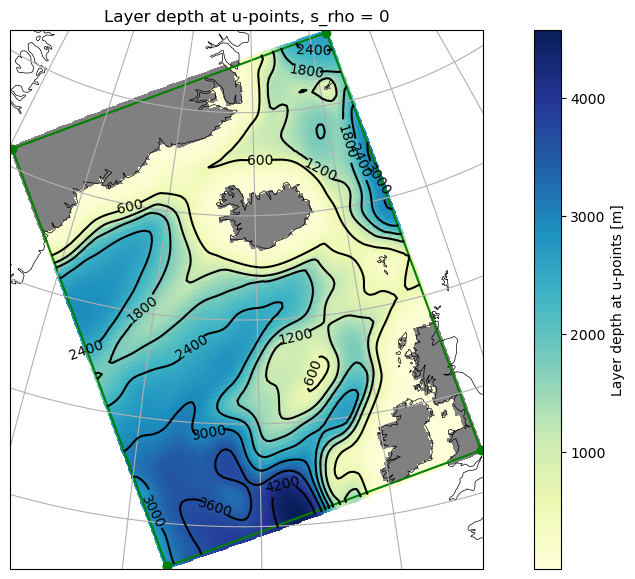

In [7]:
vertical_coordinate.plot("layer_depth_u", s=0)

Here is the depth of the uppermost layer at `rho`-points.

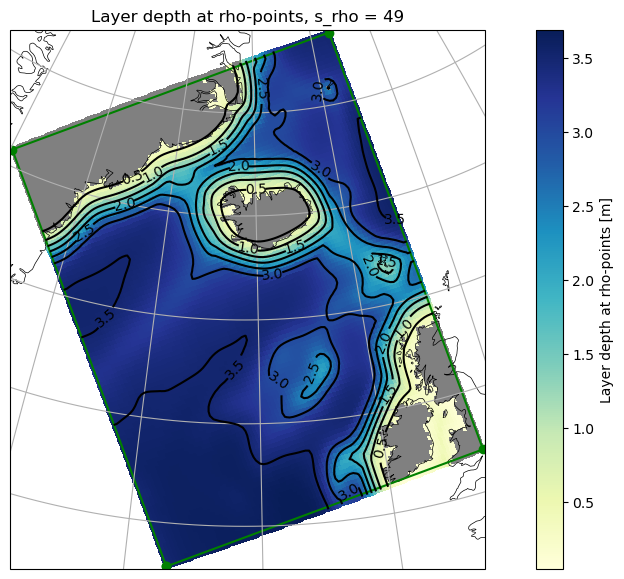

In [8]:
vertical_coordinate.plot("layer_depth_rho", s=-1)

In contrast, the depth of the uppermost interface (at `rho`-, `u`- and `v`-points) is equal to zero because the creation of the `VerticalCoordinate` object has no information about the sea surface height and assumes that it is zero everywhere. 

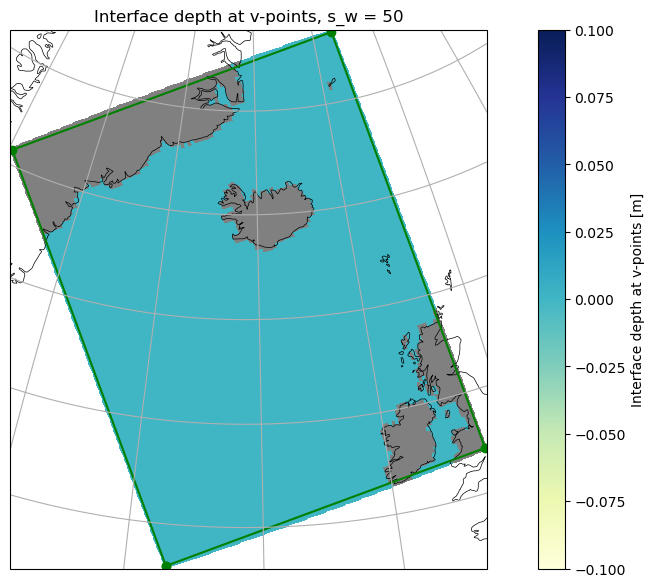

In [9]:
vertical_coordinate.plot("interface_depth_v", s=-1)

<div class="alert alert-info">

Note

The same assumption of zero sea surface height also goes into the creation of the initial conditions and the boundary forcing, for which we will use the `VerticalCoordinate` object from this notebook. Note, however, that during runtime ROMS will dynamically adjust the vertical coordinate to account for varying sea surface height.

</div>

We are now interested in a vertical view of our layers. We can look at a transect by slicing through the `eta` or `xi` dimensions.

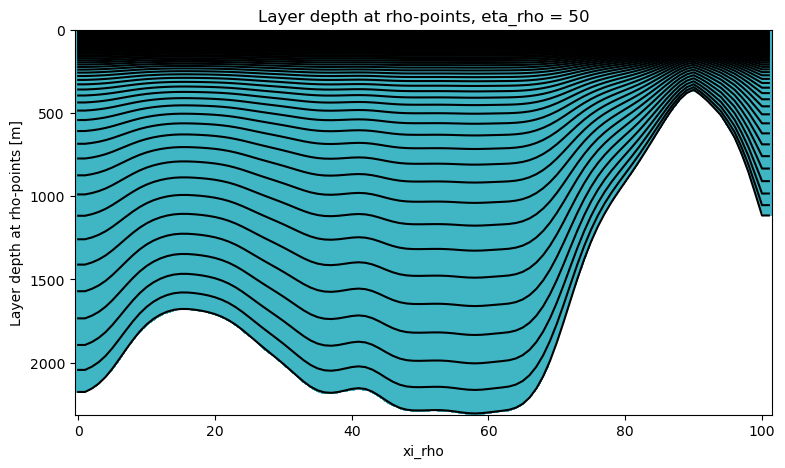

In [10]:
vertical_coordinate.plot("layer_depth_rho", eta=50)

The upper ocean layers are so densely packed that the lines converge and become indistinguishable.

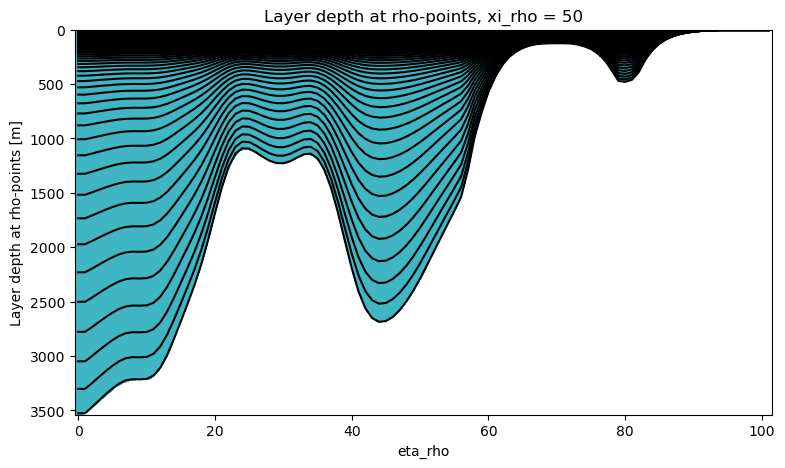

In [11]:
vertical_coordinate.plot("layer_depth_rho", xi=50)

## Saving as NetCDF or YAML file

ROMS does not need an input file that describes the vertical coordinate system, but it does need input files (such as initial conditions, boundary forcing) that are created based on a vertical coordinate system. To be able to reuse the same vertical coordinate system in subsequent steps, we may therefore be interested in saving the vertical coordinate system to file.

In [12]:
filepath = "/glade/derecho/scratch/noraloose/grids/my_vertical_coordinate.nc"

In [13]:
vertical_coordinate.save(filepath)

Alternatively you could just save the parameters of the `VerticalCoordinate` class to a YAML file. The YAML file will help you to recreate the exact same vertical coordinate system at a later point in time.

In [14]:
yaml_filepath = "/glade/derecho/scratch/noraloose/grids/my_vertical_coordinate.yaml"

In [15]:
vertical_coordinate.to_yaml(yaml_filepath)

This wrote the following YAML file.

In [16]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev44
---
Grid:
  center_lat: 61
  center_lon: -21
  hmin: 5.0
  nx: 100
  ny: 100
  rmax: 0.2
  rot: 20
  size_x: 1800
  size_y: 2400
  smooth_factor: 8
  topography_source: ETOPO5
VerticalCoordinate:
  N: 50
  hc: 400.0
  theta_b: 2.0
  theta_s: 10.0



## Creating a vertical coordinate system from an existing file
We can create a vertical coordinate system from an existing NetCDF file, for example from the one that we just saved.

In [17]:
the_same_vertical_coordinate = VerticalCoordinate.from_file(filepath)

In [18]:
the_same_vertical_coordinate.ds

<xarray.Dataset> Size: 13MB
Dimensions:              (s_rho: 50, eta_v: 101, xi_rho: 102, eta_rho: 102,
                          xi_u: 101, s_w: 51)
Coordinates:
    lat_rho              (eta_v, xi_rho) float64 82kB ...
    lon_rho              (eta_v, xi_rho) float64 82kB ...
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 2MB ...
    layer_depth_u        (eta_rho, xi_u, s_rho) float32 2MB ...
    layer_depth_v        (eta_v, xi_rho, s_rho) float32 2MB ...
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 2MB ...
    interface_depth_u    (eta_rho, xi_u, s_w) float32 2MB ...
    interface_depth_v    (eta_v, xi_rho, s_w) float32 2MB ...
Dimensions without coordinates: s_rho, eta_v, xi_rho, eta_rho, xi_u, s_w
Data variables:
    theta_s              float32 4B 10.0
    theta_b              float32 4B 2.0
    Tcline               float32 4B ...
    hc                   float32 4B 400.0
    sc_r                 (s_rho) float32 200B ...
    Cs_r                 (s_rho) float32 200B ...
Attributes:
    title:               ROMS vertical coordinate file created by ROMS-Tools
    roms_tools_version:  0.1.dev44

Or we recreate the vertical coordinate from the YAML file that we saved.

In [19]:
yet_the_same_vertical_coordinate = VerticalCoordinate.from_yaml(yaml_filepath)

In [20]:
yet_the_same_vertical_coordinate.ds

<xarray.Dataset> Size: 13MB
Dimensions:              (s_rho: 50, eta_v: 101, xi_rho: 102, eta_rho: 102,
                          xi_u: 101, s_w: 51)
Coordinates:
    lat_rho              (eta_v, xi_rho) float64 82kB 48.04 48.1 ... 73.51 73.53
    lon_rho              (eta_v, xi_rho) float64 82kB 332.9 333.1 ... 353.2
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 2MB 2.799e+03 ... 3...
    layer_depth_u        (eta_rho, xi_u, s_rho) float32 2MB 2.799e+03 ... 3.497
    layer_depth_v        (eta_v, xi_rho, s_rho) float32 2MB 2.799e+03 ... 3.497
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 2MB 2.886e+03 ... -0.0
    interface_depth_u    (eta_rho, xi_u, s_w) float32 2MB 2.886e+03 ... -0.0
    interface_depth_v    (eta_v, xi_rho, s_w) float32 2MB 2.886e+03 ... -0.0
Dimensions without coordinates: s_rho, eta_v, xi_rho, eta_rho, xi_u, s_w
Data variables:
    theta_s              float32 4B 10.0
    theta_b              float32 4B 2.0
    Tcline               float32 4B 400.0
    hc                   float32 4B 400.0
    sc_r                 (s_rho) float32 200B -0.99 -0.97 -0.95 ... -0.03 -0.01
    Cs_r                 (s_rho) float32 200B -0.9672 -0.8937 ... -1.051e-06
Attributes:
    title:               ROMS vertical coordinate file created by ROMS-Tools
    roms_tools_version:  0.1.dev44

## Vertical coordinate system parameters

### Critical depth

The critical depth `hc` sets the transition between flat $z$-levels in the upper ocean and terrain-following sigma-levels below. Usually we want to choose `hc` to be comparable with the expected depth of the pycnocline. That being said, let's experiment with the `hc` parameter. We start with a similar vertical coordinate system as generated above but this time with only `N = 20` vertical layers for instructive reasons.

In [21]:
vertical_coordinate = VerticalCoordinate(
    grid=grid,
    N=20,
    theta_s=10.0,
    theta_b=2.0,
    hc=400.0,
)

We now change the critical depth, while leaving all other parameters unchanged.

In [22]:
vertical_coordinate_with_large_critical_depth = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=vertical_coordinate.theta_s,
    theta_b=vertical_coordinate.theta_b,
    hc=1000.0,
)

vertical_coordinate_with_small_critical_depth = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=vertical_coordinate.theta_s,
    theta_b=vertical_coordinate.theta_b,
    hc=50.0,
)

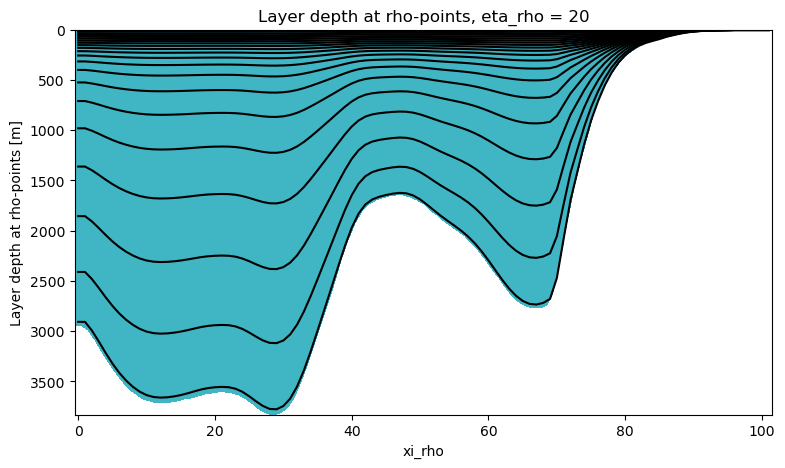

In [23]:
vertical_coordinate.plot("layer_depth_rho", eta=20)

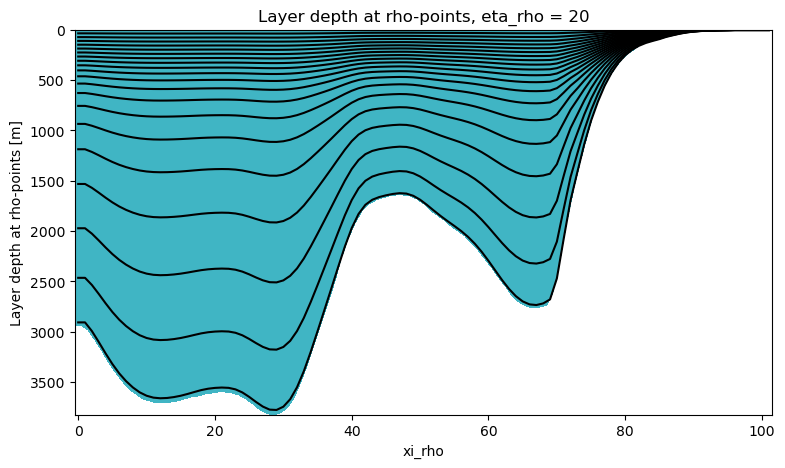

In [24]:
vertical_coordinate_with_large_critical_depth.plot("layer_depth_rho", eta=20)

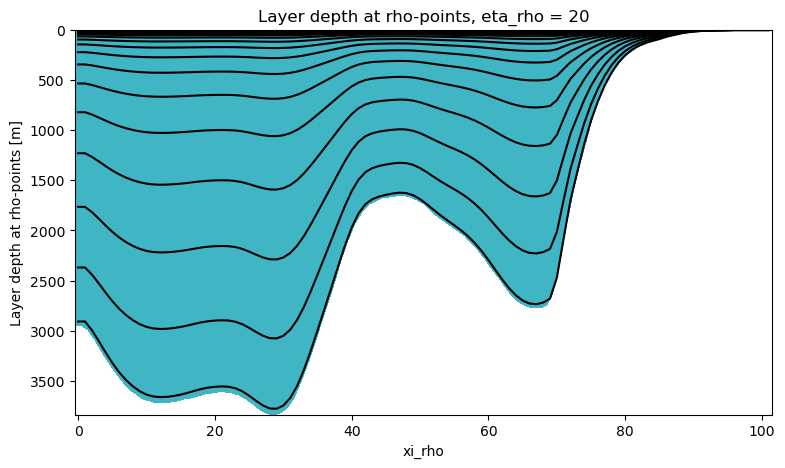

In [25]:
vertical_coordinate_with_small_critical_depth.plot("layer_depth_rho", eta=20)

When comparing the three plots above, we observe that 

* increasing `hc` results in a higher proportion of the upper ocean having nearly evenly spaced levels. It's important to note that despite setting `hc` to 1000m in the second plot, the evenly spaced levels do not extend all the way down to 1000m. However, in deeper ocean regions (visible in the left part of the plot), we approach this depth threshold more closely.
* reducing `hc` leads to a smaller proportion of the upper ocean having nearly evenly spaced levels.

### Surface and bottom control parameters

The surface control parameter `theta_s` and bottom control parameter `theta_b` determine how much the vertical grid is stretched near the surface and bottom, respectively. Let's change these two parameters and see what happens.

We start with the vertical coordinate system that we have already used above.

In [26]:
vertical_coordinate = VerticalCoordinate(
    grid=grid, N=20, theta_s=5.0, theta_b=2.0, hc=400.0
)

Let's change the surface control parameter `theta_s` but leave all other parameters unchanged.

In [27]:
vertical_coordinate_with_large_theta_s = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=10.0,
    theta_b=vertical_coordinate.theta_b,
    hc=vertical_coordinate.hc,
)

vertical_coordinate_with_small_theta_s = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=2.0,
    theta_b=vertical_coordinate.theta_b,
    hc=vertical_coordinate.hc,
)

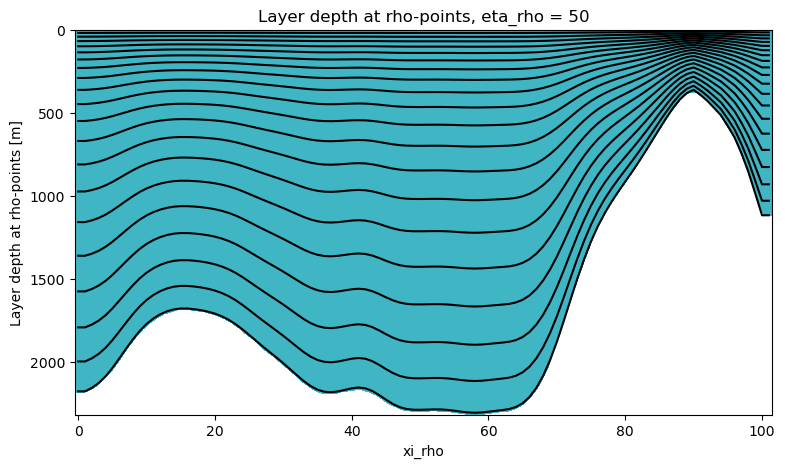

In [28]:
vertical_coordinate.plot(eta=50)

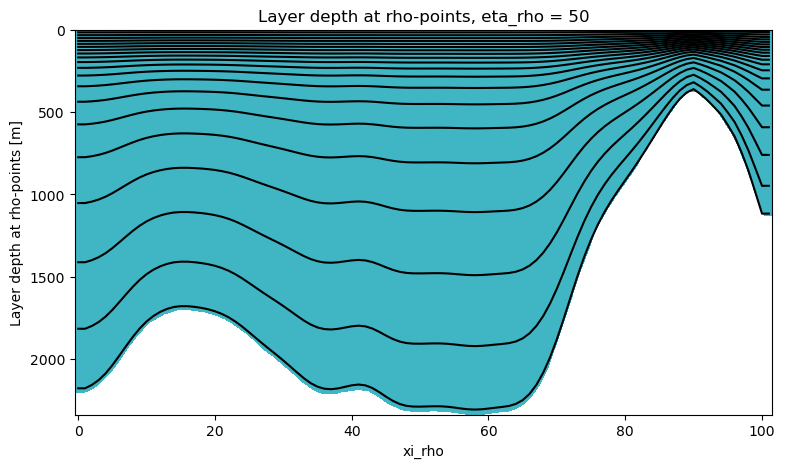

In [29]:
vertical_coordinate_with_large_theta_s.plot(eta=50)

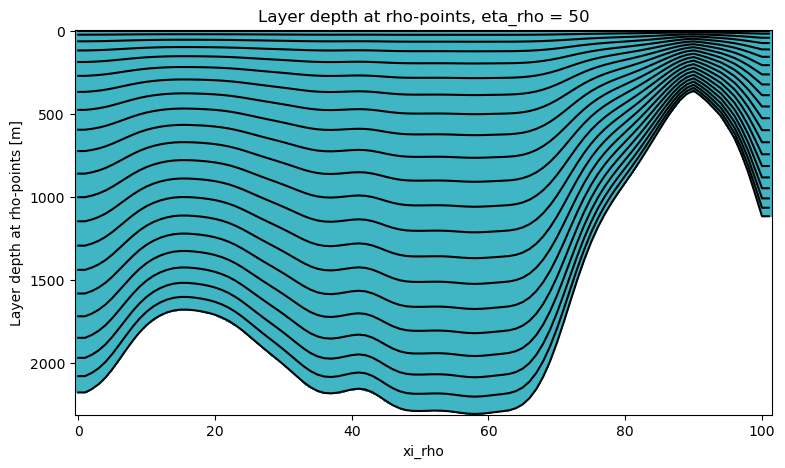

In [30]:
vertical_coordinate_with_small_theta_s.plot(eta=50)

When comparing the three plots above, we can see that 

* increasing `theta_s` leads to a refinement of the vertical grid near the surface,
* reducing `theta_s` leads to coarsening of the vertical grid near the surface.

We can play a similar game with the bottom control parameter `theta_b`.

In [31]:
vertical_coordinate_with_large_theta_b = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=vertical_coordinate.theta_s,
    theta_b=4.0,
    hc=vertical_coordinate.hc,
)

vertical_coordinate_with_small_theta_b = VerticalCoordinate(
    grid=vertical_coordinate.grid,
    N=vertical_coordinate.N,
    theta_s=vertical_coordinate.theta_s,
    theta_b=0.5,
    hc=vertical_coordinate.hc,
)

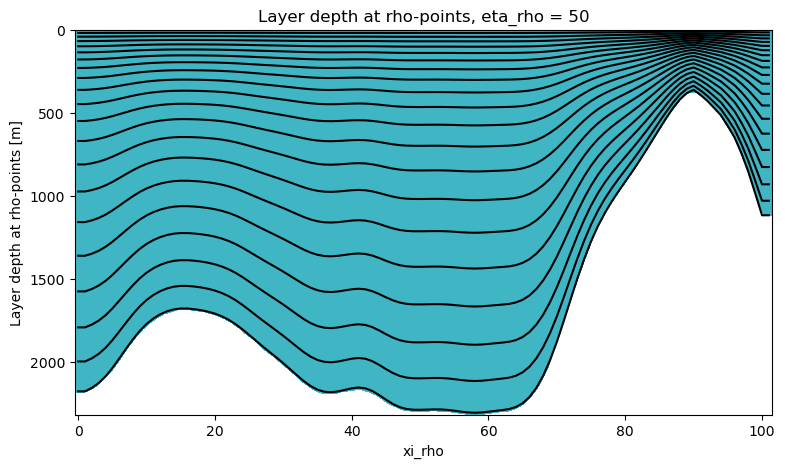

In [32]:
vertical_coordinate.plot(eta=50)

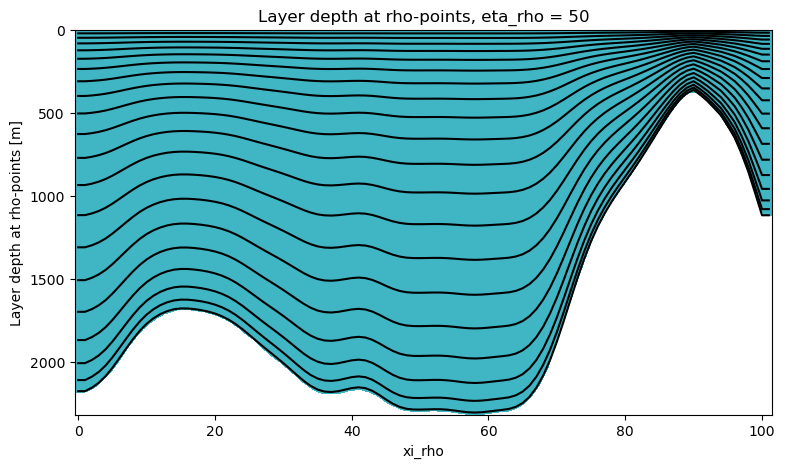

In [33]:
vertical_coordinate_with_large_theta_b.plot(eta=50)

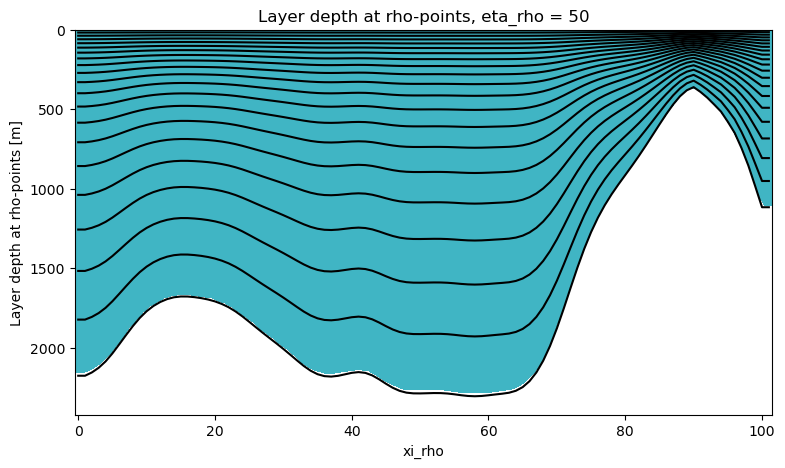

In [34]:
vertical_coordinate_with_small_theta_b.plot(eta=50)

Again, comparing the three plots above, we can see that 

* increasing `theta_b` leads to a refinement of the vertical grid near the bottom,
* reducing `theta_b` leads to coarsening of the vertical grid near the bottom.